In [1]:
import keras
import os
os.environ['KERAS_BACKEND']='tensorflow'
import h5py
import cv2
import matplotlib.pyplot as plt
import numpy as np
from os import walk
import random

np.random.seed(1337)  # for reproducibility

def setGPU():
    os.environ["CUDA_VISIBLE_DEVICES"] = "1"
    import tensorflow as tf
    from keras.backend.tensorflow_backend import set_session
    config = tf.ConfigProto()
    #config.gpu_options.per_process_gpu_memory_fraction = 0.5
    config.gpu_options.allow_growth = True
    set_session(tf.Session(config=config))
setGPU()

print('libs loaded')

Using TensorFlow backend.


libs loaded


In [2]:
# parameters
data_path = '../data/seg_data/{}/'
size = 128

def load_filenames(path):
    filenames = []
    for (dirpath, dirnames, filenames) in walk(data_path.format('x')):
        filenames.extend(filenames)
        break
    for f in filenames:
        if not '.npy' in f:
            del f
    training_filenames = []
    validation_filenames = []
    for f in filenames:
        if 'case1_' in f:
            validation_filenames.append(f)
        else:
            training_filenames.append(f)
            
            
    return training_filenames, validation_filenames
    
training_filenames, validation_filenames = load_filenames(data_path)

print(training_filenames)
print(validation_filenames)

['case10_label11.npy', 'case6_label11.npy', 'case8_label11.npy', 'case10_label6.npy', 'case9_label19.npy', 'case2_label13.npy', 'case9_label7.npy', 'case5_label3.npy', 'case6_label15.npy', 'case6_label8.npy', 'case10_label4.npy', 'case9_label13.npy', 'case3_label6.npy', 'case2_label5.npy', 'case9_label12.npy', 'case6_label9.npy', 'case3_label2.npy', 'case9_label17.npy', 'case10_label2.npy', 'case9_label10.npy', 'case8_label12.npy', 'case8_label4.npy', 'case4_label14.npy', 'case9_label5.npy', 'case4_label6.npy', 'case8_label5.npy', 'case5_label8.npy', 'case4_label3.npy', 'case8_label9.npy', 'case8_label18.npy', 'case8_label15.npy', 'case8_label10.npy', 'case9_label8.npy', 'case4_label11.npy', 'case5_label17.npy', 'case4_label12.npy', 'case3_label16.npy', 'case2_label8.npy', 'case2_label7.npy', 'case8_label19.npy', 'case3_label7.npy', 'case8_label8.npy', 'case4_label19.npy', 'case3_label15.npy', 'case6_label6.npy', 'case5_label18.npy', 'case4_label15.npy', 'case5_label5.npy', 'case4_labe

In [14]:

def model():
    from keras.models import Model
    from keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, Concatenate, BatchNormalization, Activation
    
    def conv(input_tensor, depth):
        conv_tensor = Conv3D(depth, 3, padding = 'same', kernel_initializer = 'he_normal')(input_tensor)
        bn = BatchNormalization()(conv_tensor) # use_bias=False
        output_tensor = Activation('relu')(bn)
        return output_tensor
    
    def pool(input_tensor):
        output_tensor = MaxPooling3D(pool_size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def up(input_tensor):
        output_tensor = UpSampling3D(size=(2, 2, 2))(input_tensor)
        return output_tensor
    
    def skip(input_tensor1, input_tensor2):
        output_tensor = Concatenate(axis=-1)([input_tensor1, input_tensor2])
        return output_tensor
    
    depth = 16
    
    input_img = Input(shape=(size, size, size, 1))
    
    conv1 = conv(input_img, depth)
    conv2 = conv(conv1, depth * 2)
    
    pool1 = pool(conv2)
    
    conv3 = conv(pool1, depth * 2)
    conv4 = conv(conv3, depth * 4)
    
    pool2 = pool(conv4)
    
    conv5 = conv(pool2, depth * 4)
    conv6 = conv(conv5, depth * 8)
    
    pool3 = pool(conv6)
    
    conv7 = conv(pool3, depth * 8)
    conv8 = conv(conv7, depth * 16)   

    up1 = up(conv8)
    
    skip1 = skip(conv6, up1)
    
    conv9 = conv(skip1, depth * 8)
    conv10 = conv(conv9, depth * 8)
    
    up2   = up(conv10)
    
    skip2 = skip(conv4, up2)
    
    conv11 = conv(skip2, depth * 4)
    conv12 = conv(conv11, depth * 4)
    
    up3   = up(conv12)
    
    skip3 = skip(conv2, up3)
    
    conv13 = conv(skip3, depth * 2)
    conv14 = conv(conv13, depth * 2)    
   
    conv15 = conv(conv14, 1)

    output_img = conv15

    # model
    model = Model(inputs=input_img, outputs=output_img)
    print (model.output_shape)

    # optimizer
    opt = keras.optimizers.Adam(lr=1e-2)#32-5,16-3

    model.compile(optimizer=opt,
                  loss='mse',
                  metrics=['accuracy'])
    
    model.summary()
    
    return model

model = model()

(None, 128, 128, 128, 1)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 128, 128, 128 0                                            
__________________________________________________________________________________________________
conv3d_16 (Conv3D)              (None, 128, 128, 128 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_16 (BatchNo (None, 128, 128, 128 64          conv3d_16[0][0]                  
__________________________________________________________________________________________________
activation_16 (Activation)      (None, 128, 128, 128 0           batch_normalization_16[0][0]     
____________________________________________________________________________________

In [15]:
def generator(batch_size, filenames):
    while 1:
        shape = (batch_size, size, size, size, 1)
        
        x_out = np.zeros(shape)
        y_out = np.zeros(shape)
        
        for i in range(batch_size):
            filename = random.choice(filenames)
            #filename = filenames[0]
            x = np.load(data_path.format('x') + filename)
            y = np.load(data_path.format('y') + filename)
            x = np.reshape(x, (size, size, size, -1))
            y = np.reshape(y, (size, size, size, -1))
            
            x_out[i] = x
            y_out[i] = y
            
            # bias
#             bias = 3
#             x_bias, y_bias, z_bias = random.randint(-bias,bias), random.randint(-bias,bias), random.randint(-bias,bias)
#             x_range = (x_bias, 127) if x_bias > 0 else (0, size + x_bias -1)
#             y_range = (y_bias, 127) if y_bias > 0 else (0, size + y_bias -1)
#             z_range = (z_bias, 127) if z_bias > 0 else (0, size + z_bias -1)

#             x_out[i,x_range[0]:x_range[1],y_range[0]:y_range[1],z_range[0]:z_range[1],:] = x[x_range[0]:x_range[1],y_range[0]:y_range[1],z_range[0]:z_range[1]]
#             y_out[i,x_range[0]:x_range[1],y_range[0]:y_range[1],z_range[0]:z_range[1],:] = y[x_range[0]:x_range[1],y_range[0]:y_range[1],z_range[0]:z_range[1]]
            
        yield (x_out, y_out)

In [18]:
# from keras.callbacks import EarlyStopping
# early_stopping = EarlyStopping(monitor='val_loss',
#                                min_delta=0,
#                                patience=2,
#                                verbose=0,
#                                mode='auto')
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('./save/model.weights.best.h5', verbose=1, monitor='val_loss',save_best_only=True, mode='min') 

history = model.fit_generator(  generator(1, training_filenames),
                                validation_data=generator(2, validation_filenames),
                                steps_per_epoch=10,
                                validation_steps = 10,
                                epochs=2000,
                                callbacks=[checkpoint])

Epoch 1/2000
10/10 [==============================] - 15s 1s/step - loss: 0.0063 - acc: 0.9909 - val_loss: 0.0111 - val_acc: 0.9875
Epoch 2/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0054 - acc: 0.9921 - val_loss: 0.0120 - val_acc: 0.9867
Epoch 3/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0059 - acc: 0.9915 - val_loss: 0.0136 - val_acc: 0.9851
Epoch 4/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0063 - acc: 0.9907 - val_loss: 0.0122 - val_acc: 0.9824
Epoch 5/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0059 - acc: 0.9911 - val_loss: 0.0073 - val_acc: 0.9900
Epoch 6/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0063 - acc: 0.9909 - val_loss: 0.0357 - val_acc: 0.9429
Epoch 7/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0050 - acc: 0.9930 - val_loss: 0.0114 - val_acc: 0.9831
Epoch 8/2000
10/10 [==============================] - 14s 1s/step - loss: 0.

Epoch 33/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0055 - acc: 0.9922 - val_loss: 0.0087 - val_acc: 0.9883
Epoch 34/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0060 - acc: 0.9913 - val_loss: 0.0055 - val_acc: 0.9919
Epoch 35/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0062 - acc: 0.9908 - val_loss: 0.0107 - val_acc: 0.9889
Epoch 36/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0051 - acc: 0.9927 - val_loss: 0.0105 - val_acc: 0.9876
Epoch 37/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0051 - acc: 0.9926 - val_loss: 0.0048 - val_acc: 0.9930
Epoch 38/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0044 - acc: 0.9937 - val_loss: 0.0058 - val_acc: 0.9917
Epoch 39/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0053 - acc: 0.9919 - val_loss: 0.0076 - val_acc: 0.9896
Epoch 40/2000
10/10 [==============================] - 14s 1s/step - 

Epoch 66/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0042 - acc: 0.9941 - val_loss: 0.0075 - val_acc: 0.9896
Epoch 67/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0044 - acc: 0.9938 - val_loss: 0.0063 - val_acc: 0.9907
Epoch 68/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0048 - acc: 0.9932 - val_loss: 0.0069 - val_acc: 0.9906
Epoch 69/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0049 - acc: 0.9928 - val_loss: 0.0046 - val_acc: 0.9934
Epoch 70/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0041 - acc: 0.9941 - val_loss: 0.0045 - val_acc: 0.9933
Epoch 71/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0053 - acc: 0.9921 - val_loss: 0.0140 - val_acc: 0.9773
Epoch 72/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0048 - acc: 0.9932 - val_loss: 0.0190 - val_acc: 0.9696
Epoch 73/2000
10/10 [==============================] - 14s 1s/step - 

Epoch 99/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0048 - acc: 0.9931 - val_loss: 0.0049 - val_acc: 0.9930
Epoch 100/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0040 - acc: 0.9940 - val_loss: 0.0047 - val_acc: 0.9933
Epoch 101/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0058 - acc: 0.9915 - val_loss: 0.0089 - val_acc: 0.9891
Epoch 102/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0041 - acc: 0.9944 - val_loss: 0.0118 - val_acc: 0.9880
Epoch 103/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0038 - acc: 0.9949 - val_loss: 0.0124 - val_acc: 0.9875
Epoch 104/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0054 - acc: 0.9921 - val_loss: 0.0073 - val_acc: 0.9909
Epoch 105/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0041 - acc: 0.9941 - val_loss: 0.0112 - val_acc: 0.9876
Epoch 106/2000
10/10 [==============================] - 14s 1s/

Epoch 132/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0047 - acc: 0.9933 - val_loss: 0.0057 - val_acc: 0.9920
Epoch 133/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0038 - acc: 0.9947 - val_loss: 0.0046 - val_acc: 0.9931
Epoch 134/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0044 - acc: 0.9936 - val_loss: 0.0045 - val_acc: 0.9934
Epoch 135/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0043 - acc: 0.9944 - val_loss: 0.0073 - val_acc: 0.9899
Epoch 136/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0047 - acc: 0.9938 - val_loss: 0.0161 - val_acc: 0.9765
Epoch 137/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0038 - acc: 0.9951 - val_loss: 0.0054 - val_acc: 0.9928
Epoch 138/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0037 - acc: 0.9950 - val_loss: 0.0050 - val_acc: 0.9929
Epoch 139/2000
10/10 [==============================] - 14s 1s

Epoch 165/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0043 - acc: 0.9939 - val_loss: 0.0092 - val_acc: 0.9884
Epoch 166/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0044 - acc: 0.9940 - val_loss: 0.0083 - val_acc: 0.9892
Epoch 167/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0033 - acc: 0.9958 - val_loss: 0.0086 - val_acc: 0.9898
Epoch 168/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0037 - acc: 0.9948 - val_loss: 0.0104 - val_acc: 0.9881
Epoch 169/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0032 - acc: 0.9955 - val_loss: 0.0048 - val_acc: 0.9930
Epoch 170/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0028 - acc: 0.9963 - val_loss: 0.0045 - val_acc: 0.9939
Epoch 171/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0026 - acc: 0.9966 - val_loss: 0.0056 - val_acc: 0.9920
Epoch 172/2000
10/10 [==============================] - 14s 1s

Epoch 198/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0032 - acc: 0.9956 - val_loss: 0.0117 - val_acc: 0.9876
Epoch 199/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0031 - acc: 0.9958 - val_loss: 0.0105 - val_acc: 0.9880
Epoch 200/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0029 - acc: 0.9962 - val_loss: 0.0058 - val_acc: 0.9919
Epoch 201/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0025 - acc: 0.9966 - val_loss: 0.0038 - val_acc: 0.9947
Epoch 202/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0032 - acc: 0.9956 - val_loss: 0.0067 - val_acc: 0.9906
Epoch 203/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0025 - acc: 0.9967 - val_loss: 0.0054 - val_acc: 0.9924
Epoch 204/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0023 - acc: 0.9969 - val_loss: 0.0041 - val_acc: 0.9944
Epoch 205/2000
10/10 [==============================] - 14s 1s

Epoch 231/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0038 - acc: 0.9949 - val_loss: 0.0064 - val_acc: 0.9919
Epoch 232/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0032 - acc: 0.9955 - val_loss: 0.0063 - val_acc: 0.9912
Epoch 233/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0027 - acc: 0.9965 - val_loss: 0.0054 - val_acc: 0.9920
Epoch 234/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0028 - acc: 0.9962 - val_loss: 0.0039 - val_acc: 0.9950
Epoch 235/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0033 - acc: 0.9956 - val_loss: 0.0067 - val_acc: 0.9913
Epoch 236/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0037 - acc: 0.9949 - val_loss: 0.0055 - val_acc: 0.9926
Epoch 237/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0022 - acc: 0.9971 - val_loss: 0.0059 - val_acc: 0.9920
Epoch 238/2000
10/10 [==============================] - 14s 1s

Epoch 264/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0025 - acc: 0.9965 - val_loss: 0.0073 - val_acc: 0.9908
Epoch 265/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0031 - acc: 0.9960 - val_loss: 0.0117 - val_acc: 0.9868
Epoch 266/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0033 - acc: 0.9957 - val_loss: 0.0141 - val_acc: 0.9857
Epoch 267/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0039 - acc: 0.9948 - val_loss: 0.0137 - val_acc: 0.9863
Epoch 268/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0038 - acc: 0.9948 - val_loss: 0.0095 - val_acc: 0.9888
Epoch 269/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0027 - acc: 0.9967 - val_loss: 0.0103 - val_acc: 0.9884
Epoch 270/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0032 - acc: 0.9959 - val_loss: 0.0088 - val_acc: 0.9887
Epoch 271/2000
10/10 [==============================] - 14s 1s

Epoch 297/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0017 - acc: 0.9977 - val_loss: 0.0049 - val_acc: 0.9937
Epoch 298/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0023 - acc: 0.9969 - val_loss: 0.0078 - val_acc: 0.9894
Epoch 299/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0025 - acc: 0.9967 - val_loss: 0.0085 - val_acc: 0.9891
Epoch 300/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0022 - acc: 0.9971 - val_loss: 0.0063 - val_acc: 0.9915
Epoch 301/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9982 - val_loss: 0.0086 - val_acc: 0.9892
Epoch 302/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0020 - acc: 0.9974 - val_loss: 0.0117 - val_acc: 0.9866
Epoch 303/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0028 - acc: 0.9963 - val_loss: 0.0079 - val_acc: 0.9901
Epoch 304/2000
10/10 [==============================] - 14s 1s

Epoch 330/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0020 - acc: 0.9974 - val_loss: 0.0119 - val_acc: 0.9876
Epoch 331/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0017 - acc: 0.9977 - val_loss: 0.0090 - val_acc: 0.9897
Epoch 332/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0026 - acc: 0.9967 - val_loss: 0.0100 - val_acc: 0.9881
Epoch 333/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0026 - acc: 0.9969 - val_loss: 0.0085 - val_acc: 0.9892
Epoch 334/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0021 - acc: 0.9974 - val_loss: 0.0117 - val_acc: 0.9870
Epoch 335/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0028 - acc: 0.9964 - val_loss: 0.0090 - val_acc: 0.9895
Epoch 336/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0024 - acc: 0.9968 - val_loss: 0.0059 - val_acc: 0.9928
Epoch 337/2000
10/10 [==============================] - 14s 1s

Epoch 363/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9982 - val_loss: 0.0065 - val_acc: 0.9915
Epoch 364/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0016 - acc: 0.9978 - val_loss: 0.0083 - val_acc: 0.9896
Epoch 365/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0021 - acc: 0.9972 - val_loss: 0.0087 - val_acc: 0.9896
Epoch 366/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0024 - acc: 0.9968 - val_loss: 0.0062 - val_acc: 0.9921
Epoch 367/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0017 - acc: 0.9978 - val_loss: 0.0074 - val_acc: 0.9908
Epoch 368/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0024 - acc: 0.9968 - val_loss: 0.0067 - val_acc: 0.9917
Epoch 369/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0021 - acc: 0.9974 - val_loss: 0.0064 - val_acc: 0.9921
Epoch 370/2000
10/10 [==============================] - 14s 1s

Epoch 396/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0018 - acc: 0.9977 - val_loss: 0.0065 - val_acc: 0.9919
Epoch 397/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0024 - acc: 0.9967 - val_loss: 0.0089 - val_acc: 0.9887
Epoch 398/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0018 - acc: 0.9977 - val_loss: 0.0094 - val_acc: 0.9885
Epoch 399/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0019 - acc: 0.9975 - val_loss: 0.0073 - val_acc: 0.9910
Epoch 400/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0020 - acc: 0.9973 - val_loss: 0.0070 - val_acc: 0.9918
Epoch 401/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0015 - acc: 0.9978 - val_loss: 0.0114 - val_acc: 0.9875
Epoch 402/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0021 - acc: 0.9973 - val_loss: 0.0100 - val_acc: 0.9881
Epoch 403/2000
10/10 [==============================] - 14s 1s

Epoch 429/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0015 - acc: 0.9982 - val_loss: 0.0078 - val_acc: 0.9906
Epoch 430/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0022 - acc: 0.9971 - val_loss: 0.0054 - val_acc: 0.9934
Epoch 431/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0023 - acc: 0.9970 - val_loss: 0.0088 - val_acc: 0.9900
Epoch 432/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9982 - val_loss: 0.0119 - val_acc: 0.9868
Epoch 433/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0016 - acc: 0.9979 - val_loss: 0.0076 - val_acc: 0.9911
Epoch 434/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9981 - val_loss: 0.0084 - val_acc: 0.9902
Epoch 435/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0020 - acc: 0.9974 - val_loss: 0.0065 - val_acc: 0.9919
Epoch 436/2000
10/10 [==============================] - 14s 1s

Epoch 462/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0012 - acc: 0.9983 - val_loss: 0.0096 - val_acc: 0.9888
Epoch 463/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9981 - val_loss: 0.0119 - val_acc: 0.9867
Epoch 464/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0013 - acc: 0.9983 - val_loss: 0.0102 - val_acc: 0.9883
Epoch 465/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0016 - acc: 0.9979 - val_loss: 0.0110 - val_acc: 0.9873
Epoch 466/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0015 - acc: 0.9981 - val_loss: 0.0105 - val_acc: 0.9875
Epoch 467/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9981 - val_loss: 0.0104 - val_acc: 0.9877
Epoch 468/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0011 - acc: 0.9986 - val_loss: 0.0101 - val_acc: 0.9885
Epoch 469/2000
10/10 [==============================] - 14s 1s

Epoch 495/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0017 - acc: 0.9979 - val_loss: 0.0075 - val_acc: 0.9910
Epoch 496/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0016 - acc: 0.9981 - val_loss: 0.0134 - val_acc: 0.9832
Epoch 497/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0017 - acc: 0.9979 - val_loss: 0.0082 - val_acc: 0.9903
Epoch 498/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0011 - acc: 0.9986 - val_loss: 0.0067 - val_acc: 0.9920
Epoch 499/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0016 - acc: 0.9980 - val_loss: 0.0080 - val_acc: 0.9908
Epoch 500/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0015 - acc: 0.9982 - val_loss: 0.0086 - val_acc: 0.9898
Epoch 501/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9982 - val_loss: 0.0087 - val_acc: 0.9898
Epoch 502/2000
10/10 [==============================] - 14s 1s

Epoch 528/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0010 - acc: 0.9987 - val_loss: 0.0104 - val_acc: 0.9876
Epoch 529/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0011 - acc: 0.9986 - val_loss: 0.0123 - val_acc: 0.9861
Epoch 530/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0010 - acc: 0.9987 - val_loss: 0.0110 - val_acc: 0.9876
Epoch 531/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0011 - acc: 0.9985 - val_loss: 0.0126 - val_acc: 0.9858
Epoch 532/2000
10/10 [==============================] - 14s 1s/step - loss: 9.5423e-04 - acc: 0.9987 - val_loss: 0.0109 - val_acc: 0.9872
Epoch 533/2000
10/10 [==============================] - 14s 1s/step - loss: 9.2776e-04 - acc: 0.9988 - val_loss: 0.0108 - val_acc: 0.9878
Epoch 534/2000
10/10 [==============================] - 14s 1s/step - loss: 9.7877e-04 - acc: 0.9987 - val_loss: 0.0104 - val_acc: 0.9880
Epoch 535/2000
10/10 [============================

Epoch 593/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0013 - acc: 0.9984 - val_loss: 0.0092 - val_acc: 0.9896
Epoch 594/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0012 - acc: 0.9985 - val_loss: 0.0083 - val_acc: 0.9908
Epoch 595/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0024 - acc: 0.9970 - val_loss: 0.0100 - val_acc: 0.9886
Epoch 596/2000
10/10 [==============================] - 14s 1s/step - loss: 0.0014 - acc: 0.9986 - val_loss: 0.0098 - val_acc: 0.9888
Epoch 597/2000
 4/10 [===========>..................] - ETA: 5s - loss: 0.0015 - acc: 0.9982

KeyboardInterrupt: 

In [19]:
def plot_result():
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot_result()

NameError: name 'history' is not defined

In [23]:

#model.save_weights('./save/model_weights.h5')

In [25]:
del model

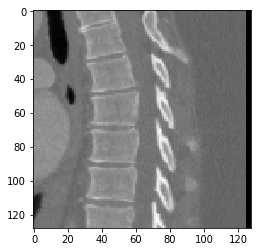

In [11]:
x = np.load(data_path.format('x') + validation_filenames[0])
plt.imshow(x[:,:,65], cmap='gray')
x = np.reshape(x, (1, 128, 128, 128, -1))

(1, 128, 128, 128, 1)
1.2680912


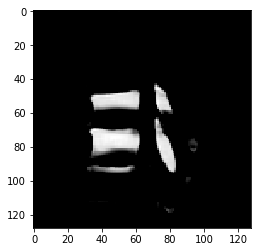

In [20]:
y = model.predict(x)
print(y.shape)
y = np.reshape(y, (128, 128, 128))
print(np.max(y))
plt.imshow(y[:,:,65], cmap='gray')

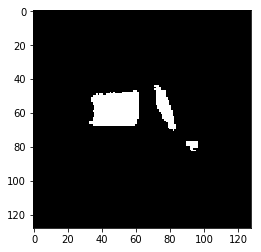

In [13]:
y = np.load(data_path.format('y') + validation_filenames[0])
plt.imshow(y[:,:,65], cmap='gray')

In [24]:
model.load_weights('./save/model.weights.best.h5')

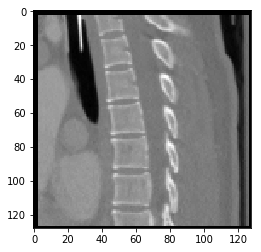

In [35]:
import random

def generator(batch_size, filenames):
    size = 128
    shape = (batch_size, size, size, size, 1)

    x_out = np.zeros(shape)
    y_out = np.zeros(shape)

    for i in range(batch_size):
        filename = random.choice(filenames)
        #filename = filenames[0]
        x = np.load(data_path.format('x') + filename)
        y = np.load(data_path.format('y') + filename)
        x = np.reshape(x, (size, size, size, -1))
        y = np.reshape(y, (size, size, size, -1))
        #x_out[i] = x
        #y_out[i] = y
    
        # bias
        bias = 3
        x_bias, y_bias, z_bias = random.randint(-bias,bias), random.randint(-bias,bias), random.randint(-bias,bias)
        x_range = (x_bias, 127) if x_bias > 0 else (0, size + x_bias -1)
        y_range = (y_bias, 127) if y_bias > 0 else (0, size + y_bias -1)
        z_range = (z_bias, 127) if z_bias > 0 else (0, size + z_bias -1)
        
        x_out[i,x_range[0]:x_range[1],y_range[0]:y_range[1],z_range[0]:z_range[1],:] = x[x_range[0]:x_range[1],y_range[0]:y_range[1],z_range[0]:z_range[1]]
    
    

    #yield (x_out, y_out)
    x_out = np.reshape(x_out, (128, 128, 128))
    plt.imshow(x_out[:,:,65], cmap='gray')
        
generator(1, training_filenames)

In [31]:
print(random.randint(-2,2))

1


In [25]:
    x_bias, y_bias, z_bias = random.randint(-2,2), random.randint(-2,2), random.randint(-2,2)
    x_range = (x_bias, 127) if x_bias > 0 else (0, size + x_bias -1)
    y_range = (y_bias, 127) if y_bias > 0 else (0, size + y_bias -1)
    z_range = (z_bias, 127) if z_bias > 0 else (0, size + z_bias -1)
    print(x_range)

(0, 125)
